# Address-AutoComplete-Bot

This notebook shows the end-to-end process of training and building a Address Autocomplete Bot using Global Attention Mechanism.

## Table of Contents

- [1 - Idea](#1)
- [2 - Review](#2)
- [3 - Address Datasets](#3)
    - [3.1 - Training Data Generation](#3-1)
    - [3.2 - Data Processing](#3-2)
- [4 - Encoder, Attention, and Decoder](#4)
    - [4.1 - Encoder](#4-1)
    - [4.2 - Attention](#4-2)
    - [4.3 - Decoder](#4-3)
    - [4.4 - Shape Check](#4-4)
- [5 - Training](#5)
- [6 - Inference](#6)

<a id="1"></a>
## 1 - Idea

Address is one of the most important pieces of data to get right for all transactions in life. When we input the correct address into a website, we ensure that the products are delivered to the right address, improve customer satisfaction, and reduce the risk of fraud. My wife and I buy hundreds of items across dozens of websites, and it's hard to imagine what would happen if the address was incorrect. Luckily, Google has services like the [Maps API](https://developers.google.com/maps/documentation/javascript), which eliminates these concerns. These map APIs are widely available, lightweight, and easy to deploy. They can be used to build dynamic and interactive maps for web applications using geospatial data, ensuring that customers never enter the wrong address again. For example, the [Place Autocomplete Address Form](https://developers.google.com/maps/documentation/javascript/examples/places-autocomplete-addressform) helps to accurately supply address details. The Place Autocomplete Address Form sample captures selected address components from the Google Places database, and uses them to populate an address form.

Recently, I completed the [Deep Learning Specialization](https://www.deeplearning.ai/courses/deep-learning-specialization/) course from Andrew NG. In this class, I learned about the attention mechanism. The attention mechanism is a powerful neural network technique that has revolutionized the field of Natural Language Processing (NLP). It allows models to focus on specific parts of their input data, which is essential for learning long-range dependencies and understanding the context of complex sequences. Attention mechanisms have been shown to significantly improve the performance of Large Language Models (LLMs) on a variety of tasks, including machine translation, text summarization, and question answering.

One question I have in mind is whether it is possible to train an LLM to predict accurate and complete addresses without requiring any geospatial knowledge. While it is known that LLMs are capable of learning complex and non-linear relationships between features and predictions on tabular data, it is unclear whether they can perform well on address correction (i.e., text generation) without knowing the meaning of individual address components such as street names, cities, and states.

This project aims to develop an address autocomplete bot that uses the attention mechanism to autocomplete addresses without requiring any geospatial knowledge. The bot will be trained on a large dataset of correctly formatted addresses, and will use the attention mechanism to learn the relationships between different address components. When given an inaccurate address, the bot will be able to detect the errors and autocomplete the address by filling in missing components or correcting incorrect components.

*References*
  - [Effective Approaches to Attention-based Neural Machine Translation (Luong et al., 2015)](https://arxiv.org/abs/1508.04025v5)
  - [Neural Machine Translation with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

<a id="2"></a>
## 2 - Review

Deep learning methods are being used in solving NLP quesitons since the early 2000s. Deep learning methods are a type of neural network that can learn complex relationships in data. In 2010s, we witness the rise of large language models (LLMs). LLMs are trained on massive datasets of text and code, which allows them to learn the statistical relationships between words and phrases at an unprecedented scale. In the paragraph below, I will summarize the development of deep learning methods on NLP, from Recurrent Neural Network (RNN), Long Short-Term Memory (LSTM), to the recent developed Attention Mechanism. 

- **Recurrent Neural Networks (RNNs)**

RNN are a type of neural network that can process sequences of data. They are the first type of neural networks that are able to learn long-term dependencies within text data, making them the first choice to solve NLP problems. However, one of the disadvantages of RNN is that they are prone to "vanishing gradient". The vanishing gradient problem is a major obstacle to training RNNs to learn long-term dependencies. This is because long-term dependencies require the network to remember information from many time steps ago, and the vanishing gradient problem makes it difficult for the network to do this.

A language example can easily demonstrate this idea of long-term dependencies. In the sentence below, the verb `has` is influenced by the word `Dog` at the very beginning. If the word `Dog` is changed to a plural form, then the verb `has` would need to be updated to the word `have`. This long-range dependencies can extend over a very long step, as we do not know how many words (aka steps) are in between these two words.

<div style="text-align: center;">
<img src="image/language_example.png" width="500"> <br>
<caption><center><b>Figure 1</b>: A language example </center></caption>
</div>

A standard RNN neural network architecture is shown below. In order to learn the long-term dependencies relationship, we hope the model is able to pass on the hidden state $a^{\langle 2 \rangle}$ to the position of $x^{\langle T_{x} \rangle}$. The basic RNNs that we have seen so far are not very good at handling such long-term dependencies, mainly due to the Vanishing Gradient Problem. When the gradients traverse through multiple steps it become very small, which makes it difficult for the network to learn.

<div style="text-align: center;">
<img src="image/rnn.png" width="500"> <br>
<caption><center><b>Figure 2</b>: Basic RNN Structure </center></caption>
</div>

- **Long Short-Term Memory (LSTM)**

LSTMs are a type of RNN that address the vanishing gradient problem. They do this by using gates to control the flow of information in the network. The figure below shows the operations of an LSTM cell.

The gates in a LSTM cell are described below:

- Forget Gate ($\mathbf{\Gamma}_{f}$): The forget gate can be used to *"forget"* the previous state. For example, if the subject changes from a singular word `Dog` to a plural `Dogs`, the memory of the previous state becomes outdated and should be forgotten. 

- Update Gate ($\mathbf{\Gamma}_{i}$): The update gate can be used to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$. The candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ is a tensor containing information from the current time step that **may** be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$. The current cell state $\mathbf{c}^{\langle t \rangle}$ is the "memory" that gets passed onto future time steps.

- Output Gate ($\mathbf{\Gamma}_{o}$): The output gate decides what gets sent as the prediction (output) of the time step.

The LSTM unit can remember long-term dependencies because the cell state is not updated at every time step, as shown in formula 4. This allows the LSTM unit to retain information from previous time steps, even if it is not used in the current time step.

<div style="text-align: center;">
<img src="image/lstm.png" width="500"> <br>
<caption><center><b>Figure 3</b>: LSTM Cell </center></caption>
</div>

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$
$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$ 
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$
$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$
$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$ 
$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

- **Attention Mechanism**

LSTM solves the vanishing gradient problem as it allows the cell state to flow through multiple time steps. However, in the language example above, the word `has` does not rely on any other word in the sentence other than the word `dog`. Attention Mechanism was developed to allow the neural network to put more weight on certain long-range dependencies than others at each position $x^{\langle T_{x} \rangle}$, hence the word "Attention".

The attention mechanism was first proposed by __[Neural Machine Translation by Jointly Learning to Align and Translate (Bahdanau et al., 2014)](https://arxiv.org/abs/1409.0473)__, and its a powerful tool that has revolutionized the field of NLP.  Attention Mechanism is commonly used with the encoder-decoders network family. The encoder encodes a source sentence into a fixed-length tensor. The attention mechanism then calcualtes a score for each word, indicating how important the word is to the current position $x^{\langle T_{x} \rangle}$. When the score is higher, the network will pay more attention to this word for the current output $y^{\langle T_{x} \rangle}$. When the score is lower, the network pay less attention.

The figure below shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$. $s^{\langle t-1 \rangle}$ is the one-step prior hidden state from the post-attention decoder, and $a^{\langle t' \rangle}$ is the hidden state from the pre-attention encoder. $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network with a dense layer to learn and compute the output $e^{\langle t, t' \rangle}$. $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$. 

Finally, the $context^{ \langle t \rangle }$ works as a weighted average of all the attention weights. Then, the decoder's output along with the context vector is used to predict the next output $y^{\langle T_{x+1} \rangle}$

$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

<div style="text-align: center;">
<img src="image/attn_mechanism.png" width="500"> <br>
<caption><center><b>Figure 4</b>: Attention Mechanism </center></caption>
</div>

<a id="3"></a>
## 3 - Datasets

The address data is downloaded from the [New York State Geographic Information System (GIS)](https://gis.ny.gov/) website. We will only train this bot on the larger NY area addresses (Manhattan, Brooklyn, Queens, Bronx, Staten Island) for demonstration purpose and to minimize network training time.
The address dataset download direction can be found [here](https://gis.ny.gov/system/files/documents/2023/03/how-to-create-county-filters-of-nys-address-point-data.pdf).

The dataset has the below columns: 

|**Column Name**|**Type**|
|------|------|
|AddressNumber|int|
|StreetName|string|
|PostType|string|
|CountyName|string|
|CityTownName|string|
|ZipName|string|
|ZipCode|int|
|State|string|

In [1]:
import pandas as pd
import numpy as np
import utils
import seaborn as sns
import tensorflow as tf
import tensorflow_text as tf_text

c:\Users\gkchen\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
ny_address = pd.read_parquet('Datasets/NYS_clean.parquet.gz', engine='pyarrow')
print(f'Dataset shape: {ny_address.shape}')
ny_address.sample(5)

Dataset shape: (746396, 8)


,AddressNumber,StreetName,PostType,CountyName,CityTownName,ZipName,ZipCode,State
5310541,64,50,Ave,Queens,New York,Corona,11368,NY
4351709,9,125,St,Queens,New York,South Richmond Hill,11419,NY
5410919,321,34,St,New York,New York,New York,10016,NY
5399431,430,84,St,New York,New York,New York,10028,NY
5507966,742,43,St,Kings,New York,Brooklyn,11203,NY


In [9]:
# Checking the County Distribution: 
# 62% of the addresses are in Kings (Brooklyn borough) and Quees (Queens borough) county.
ny_address['CountyName'].value_counts(normalize=True)

Kings          0.386011
Queens         0.234193
Richmond       0.166930
Bronx          0.136503
New York       0.076250
Nassau         0.000074
Westchester    0.000039
Name: CountyName, dtype: float64

In [11]:
# Checking the length for each address component. 
# Max word length is an important parameter for the word embedding that will happen later
for col_i in ny_address.columns:
    print(f'{col_i} has max length of {ny_address[col_i].astype(str).apply(len).max()}')

AddressNumber has max length of 5
StreetName has max length of 28
PostType has max length of 6
CountyName has max length of 11
CityTownName has max length of 8
ZipName has max length of 19
ZipCode has max length of 5
State has max length of 2


<a id="3-1"></a>
## 3-1 - Training Data Generation

In [2]:
import utils
from importlib import reload
utils = reload(utils)

To train the neural network to output the correct complete address, we need to teach it the relationships between different address components. We do this by generating training data by "masking" certain address components. The `context_raw` dataframe contains the "masked" addresses, and the `target_raw` dataframe contains the complete addresses. We sample with replacement so that one address can be used for multiple training data points.

The figure below illustrates the training data generation process. For example, if we mask one complete address three different ways, we will generate three training data points.

One limitation of this method is that not all training data points are equally helpful to the model. This is due to the hierarchical structure of address components. For example, training data point No. 3 will be helpful to the model because we want it to learn to output the most likely zip code for `321 34th St, New York, New York`, which is `10016`. However, training data point No. 1 will not be as helpful, because many addresses can have the zip code `10016`. We expect the model cost function to reduce more with training data point No. 3 than with training data point No. 1.

<div style="text-align: center;">
<img src="image/mask_generate.PNG" width="800"> <br>
<caption><center><b>Figure 5</b>: Training Data Generation Process </center></caption>
</div>

In [14]:
context_raw,target_raw = utils.create_label_target('Datasets/NYS_clean.parquet.gz')
print(f'Context shape: {context_raw.shape}')
print(f'Target shape: {target_raw.shape}')

Context shape: (2000000,)
Target shape: (2000000,)


In [18]:
random_numbers = np.random.choice(len(context_raw), 1)[0]
print(f'Masked Address: {context_raw[random_numbers]}')
print(f'Complete Address: {target_raw[random_numbers]}')


Masked Address: 4015 Church Kings NY 11203
Complete Address: 4015 Church Ave Brooklyn Kings NY 11203


In [3]:
# np.save("Datasets/context_raw.npy", context_raw)
# np.save("Datasets/target_raw.npy", target_raw)

context_raw = np.load("Datasets/context_raw.npy")
target_raw = np.load("Datasets/target_raw.npy")

<a id="3-2"></a>
## 3-2 - Data Processing

**Step 1**: Split the dataset into 80% `train_raw` and 20% `val_raw`. Create a `tf.data.Dataset` for these strings. `tf.data.Dataset` is designed to be efficient, both in terms of memory usage and runtime performance. It can automatically parallelize data loading and processing, and it can also be used to cache data in memory or on disk to improve performance.

In [4]:
import tensorflow as tf
import tensorflow_text as tf_text

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

**Step 2**: We can use the `tf.keras.layers.TextVectorization` to apply preprocessing to the text, and maps text features to integer token sequences. The text standardization is handled by the `utils.tf_lower_and_split_punct`.

In [5]:
# This parameters defines the saximum size of the vocabulary for this layer
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

# The adapt method reads one epoch of the training data, and works a lot like Model.fit. 
# This method initializes the layer based on the data.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [6]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))

In [31]:
# The context_text_processor convert a address into a token sequences
# The [START] and [END] represents the Start of String token and End of String token. These tokens will tell the model when to start and stop the prediction.
example_text = tf.constant('68 96 St Brooklyn Kings NY 11212')
example_tokens = context_text_processor(example_text)
print(f'Address To token: {example_tokens}')

context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens.numpy()]
print('Token back to Address')
print(' '.join(tokens))


Address To token: [  2 141 218   5   7   6   4 128   3]
Token back to Address
[START] 68 96 st brooklyn kings ny 11212 [END]


**Step 3**: Convert the `tf.data.Dataset` to 0-padded tensors of token. The `target_in` and `target_out` is shifted by one step relative to each other. 

In [7]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [8]:
tf.data.Dataset.save(train_ds, "Datasets/train_ds.tfds")
tf.data.Dataset.save(val_ds, "Datasets/val_ds.tfds")

<a id="4"></a>
# 4 - Encoder, Attention, and Decoder

<a id="4-1"></a>
## 4-1 - Encoder

The goal of the encoder is to process the context sequence $x^{\langle T_{x} \rangle}$ (in our case, the address string) into a sequence of vectors that the decoder can use to predict the next output $y^{\langle T_{x+1} \rangle}$.
<br>
<br>
The details of the encoder network is listed below:

1. `tf.keras.layers.Embedding`: An embedding layer that convert postive integers (i.e., tokens) into dense vectors

2. `tf.keras.layers.Bidirectional`: A bi-directional wrapper for RNNs. Here we use a GRU unit with 256 neurons. The reason we choose a bi-directional GRU is because the hidden state should flow both ways in the encoder. For example, in the exmample address of `4015 Church Ave Brooklyn Kings NY 11203`, the borough component `Brooklyn` should have the hidden state flow from the prior component `4015 Church Ave` and also from the post component `Kings NY 11203`.


In [9]:
UNITS = 256

class GRU_Encoder(tf.keras.layers.Layer):
    """An encoder model that encodes input sequences into hidden states."""

    def __init__(self, text_processor, units=UNITS):
        """Initializes the encoder.

        Args:
            text_processor: A text processor that can be used to convert text sequences to tensors and vice versa.
            units: The dimension of the hidden states.
        """

        super(GRU_Encoder, self).__init__()

        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer='glorot_uniform'))

    def call(self, x):
        """Encodes the input sequences.

        Args:
            x: A tensor of shape `[batch_size, max_sequence_length]`.

        Returns:
            A tensor of shape `[batch_size, max_sequence_length, units]`.
        """

        # Check the shape of the input tensor.
        shape_checker = utils.ShapeChecker()
        shape_checker(x, 'batch s')

        # Embed the input sequences.
        x = self.embedding(x)

        # Check the shape of the embedded input sequences.
        shape_checker(x, 'batch s units')

        # Encode the input sequences using the bidirectional LSTM layer.
        x = self.rnn(x)

        # Check the shape of the encoded input sequences.
        shape_checker(x, 'batch s units')

        return x

    def convert_input(self, texts):
        """Converts the input texts to a tensor of hidden states.

        Args:
            texts: A list of strings.

        Returns:
            A tensor of shape `[batch_size, max_sequence_length, units]`.
        """

        # Convert the input texts to a tensor of text sequences.
        texts = tf.convert_to_tensor(texts)

        # If the input tensor is a scalar, convert it to a vector.
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]

        # Convert the text sequences to a tensor of hidden states.
        context = self.text_processor(texts).to_tensor()
        context = self(context)

        return context

<a id="4-2"></a>
## 4-2 - Attention

The attention layer allows the decoder to access the information extracted by the encoder. It computes a `context vector` from the entire context sequence, and adds that to the decoder's output.
<br>
<br>
The details of the attention layer is listed below:

1. `tf.keras.layers.MultiHeadAttention`: A single head attention layer (num_heads = 1). The `key_dim` is set to 256. This means the attention head for the `query` and `key` will have dimension = 256.

    The components of the attention layer is specified here:
      * `Batch`: $b$. Number of records in each batch  
      * `t`: $t$. Input sequence dimension
      * `s`: $s$. Context sequence dimension
      * `heads`: $h$. Number of attention heads
      * `key_dim`: $key{\_}dim$. Number of hidden units from the GRU layer

    The matrices dimension for each attention component:
      * `Query`:  ($b$,$t$,$key{\_}dim$)
      * `Value`:  ($b$,$s$,$key{\_}dim$)
      * `Attention Weights`: ($b$, $t$, $s$)

2. `tf.keras.layers.Add`: Concatting the attention output along with the input `X`

3. `tf.keras.layers.LayerNormalization`: Normalize the activations of the previous layer for each given example in a batch independently, not across examples.

In [10]:
class CrossAttention(tf.keras.layers.Layer):
    """A cross-attention layer that attends to a context sequence to compute a new representation of an input sequence.

    Args:
        units: The dimension of the hidden states.
        kwargs: Additional arguments to pass to the MultiHeadAttention layer.
    """

    def __init__(self, units, **kwargs):
        super().__init__()

        # Create a MultiHeadAttention layer.
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)

        # Create a LayerNormalization layer.
        self.layernorm = tf.keras.layers.LayerNormalization()

        # Create an Add layer.
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        """Computes the cross-attention output.

        Args:
            x: A tensor of shape `[batch_size, input_sequence_length, units]`.
            context: A tensor of shape `[batch_size, context_sequence_length, units]`.

        Returns:
            A tensor of shape `[batch_size, input_sequence_length, units]`.
        """

        # Check the shape of the input tensors.
        shape_checker = utils.ShapeChecker()
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        # Compute the attention output and attention scores.
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Check the shape of the attention output and attention scores.
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Reduce the attention scores to a single head.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)

        # Check the shape of the reduced attention scores.
        shape_checker(attn_scores, 'batch t s')

        # Store the attention weights for later use.
        self.last_attention_weights = attn_scores

        # Compute the new representation of the input sequence.
        x = self.add([x, attn_output])

        # Normalize the new representation of the input sequence.
        x = self.layernorm(x)

        return x

    def get_shape(self):
        """Prints the shape of the weights of the MultiHeadAttention layer."""
        weight_names = ['query', 'keys', 'values', 'proj']
        for name, out in zip(weight_names,self.mha.get_weights()):
            print(name, out.shape)

<a id="4-3"></a>
## 4-3 - Decoder

The goal of the decoder is to generate predictions for the next token at each location in the target sequence.
<br>
<br>


The decoder takes two input:
1. `Context`: The context vector from the encoder's output.
2. `x`: The target sequence input.

The details of the decoder is specified below:
1. `tf.keras.layers.Embedding`: An embedding layer that converts token IDs to vectors. This layer is similar between both encoder and decoder.
2. `tf.keras.layers.GRU`: A unidirectional GRU layer. During training, the hidden state in the decoder should only flow in one direction because the model predicts the next word at each location.
3. `CrossAttention`: The RNN output will be the query for the attention layer.
4. `tf.keras.layers.Dense`: A dense layer that produces the logit probability for each output token.

In [11]:
class GRU_Decoder(tf.keras.layers.Layer):
    """This class defines a decoder for a sequence-to-sequence model. It uses an LSTM to generate the next token in the sequence, and an attention mechanism to attend to the encoder output.

    Args:
        text_processor: A TextProcessor object.
        units: The number of units in the LSTM layer.
    """

    def __init__(self, text_processor, units):
        super(GRU_Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
        # The embedding layer converts the input tokens into dense vectors.

        self.rnn = tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        # The GRU layer generates the next token in the sequence, based on the previous tokens and the encoder output.

        self.attention = CrossAttention(units)
        # The attention layer attends to the encoder output, and uses the attended information to generate the next token.

        self.output_layer = tf.keras.layers.Dense(self.vocab_size, activation = 'sigmoid')
        # The output layer converts the dense vectors generated by the GRU layer into probabilities over the next token.

    def call(self,
            context, x,
            state=None,
            return_state=False):  
        """
            Decodes a sequence of tokens based on the context.

            Args:
              context: A tensor of shape (batch_size, encoder_seq_len, encoder_units).
              x: A tensor of shape (batch_size, target_seq_len).
              state: A tuple of tensors, (h_state, c_state), of shape (batch_size, units).
              return_state: Whether to return the state of the decoder.

            Returns:
              A tensor of shape (batch_size, target_seq_len, target_vocab_size) containing the logits for the next token in the sequence.
            """

        shape_checker = utils.ShapeChecker()
        shape_checker(x, 'batch t')
        shape_checker(context, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        shape_checker(x, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        shape_checker(x, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        shape_checker(x, 'batch t units')
        shape_checker(self.last_attention_weights, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        shape_checker(logits, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result

    def get_next_token(self, context, next_token, done, state, random = False):
        logits, state = self(
            context, next_token,
            state = state,
            return_state=True) 

        if not random:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/1
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state, logits

<a id="4-4"></a>
## 4-4 - Shape Check

In the Deep Learning Specialization course, I learned that it's important to check the matrix shape at every step of the network to prevent weird issues and identify problems early. In this section, we'll pass through one single training datapoint through the network and check the matrix shape for each steps in the network.

1. `train_ds`: This is a `tensorflow.python.data.ops.dataset_ops.ParallelMapDataset` dataset with the format of `((context, target_in), target_out)`. `target_out` and `target_in` are target vectors but shifted by one time step

In [12]:
# Check one training sample
context_layer = tf.keras.layers.StringLookup(vocabulary=context_text_processor.get_vocabulary(),mask_token='', oov_token='[UNK]',invert=True)
target_layer = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(),mask_token='', oov_token='[UNK]',invert=True)

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print('Context Vector:')
  print(context_layer(ex_context_tok[0, :10]))
  print('\n')
  print('Target-In Vector:')
  print(target_layer(ex_tar_in[0, :10]))
  print('\n')
  print('Target-Out Vector:')
  print(target_layer(ex_tar_out[0, :10]))

Context Vector:
tf.Tensor(
[b'[START]' b'18' b'ramona' b'ave' b'staten' b'island' b'richmond'
 b'[END]' b''], shape=(9,), dtype=string)


Target-In Vector:
tf.Tensor(
[b'[START]' b'18' b'ramona' b'ave' b'staten' b'island' b'richmond' b'ny'
 b'10312' b''], shape=(10,), dtype=string)


Target-Out Vector:
tf.Tensor(
[b'18' b'ramona' b'ave' b'staten' b'island' b'richmond' b'ny' b'10312'
 b'[END]' b''], shape=(10,), dtype=string)


2. `Encoder`: The encoder has an input dimension of ($b$, $s$), and an output dimension of ($b$, $s$, $dim$).

In [13]:
encoder = GRU_Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 9)
Encoder output, shape (batch, s, units): (64, 9, 256)


3. `Attention Layer`: The context sequence from the encoder has a dimension of ($b$, $s$, $dim$). The final output of the attention layer has the same dimension as the target sequence ($b$, $t$, $dim$).

In [14]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 9, 256)
Target sequence, shape (batch, t, units): (64, 10, 256)
Attention result, shape (batch, t, units): (64, 10, 256)
Attention weights, shape (batch, t, s):    (64, 10, 9)


4. `Decoder`: The output of the decoder will have the dimension of ($b$, $t$, $vocab_size$). Given the context and target tokens, for each target token it predicts the next target token.

In [15]:
decoder = GRU_Decoder(target_text_processor, UNITS)

logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 9, 256)
input target tokens shape: (batch, t) (64, 10)
logits shape shape: (batch, target_vocabulary_size) (64, 10, 5000)


<a id="5"></a>
# 5 - Training

In [16]:
class Addressor(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = GRU_Encoder(context_text_processor, units)
        decoder = GRU_Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        return logits

In [17]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [18]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [19]:
model = Addressor(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

model.compile(optimizer='adam',
                  loss=masked_loss, 
                  metrics=[masked_acc, masked_loss])

print(model.summary())

Model: "addressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru__encoder_1 (GRU_Encoder  multiple                 2069504   
 )                                                               
                                                                 
 gru__decoder_1 (GRU_Decoder  multiple                 3223432   
 )                                                               
                                                                 
Total params: 5,292,936
Trainable params: 5,292,936
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10


c:\Users\gkchen\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 [==============================] - 41s 286ms/step - loss: 2.9617 - masked_acc: 0.4817 - masked_loss: 3.5548 - val_loss: 1.9497 - val_masked_acc: 0.6017 - val_masked_loss: 2.3585
Epoch 2/10
100/100 [==============================] - 22s 219ms/step - loss: 1.6365 - masked_acc: 0.6668 - masked_loss: 1.9847 - val_loss: 1.2651 - val_masked_acc: 0.7512 - val_masked_loss: 1.5026
Epoch 3/10
100/100 [==============================] - 22s 215ms/step - loss: 0.9770 - masked_acc: 0.8073 - masked_loss: 1.1757 - val_loss: 0.7749 - val_masked_acc: 0.8458 - val_masked_loss: 0.9254
Epoch 4/10
100/100 [==============================] - 22s 215ms/step - loss: 0.6363 - masked_acc: 0.8724 - masked_loss: 0.7665 - val_loss: 0.5196 - val_masked_acc: 0.8923 - val_masked_loss: 0.6369
Epoch 5/10
100/100 [==============================] - 21s 213ms/step - loss: 0.4533 - masked_acc: 0.9039 - masked_loss: 0.5473 - val_loss: 0.3894 - val_masked_acc: 0.9146 - val_masked_loss: 0.4661
Epoch 6/10
100/100 [======

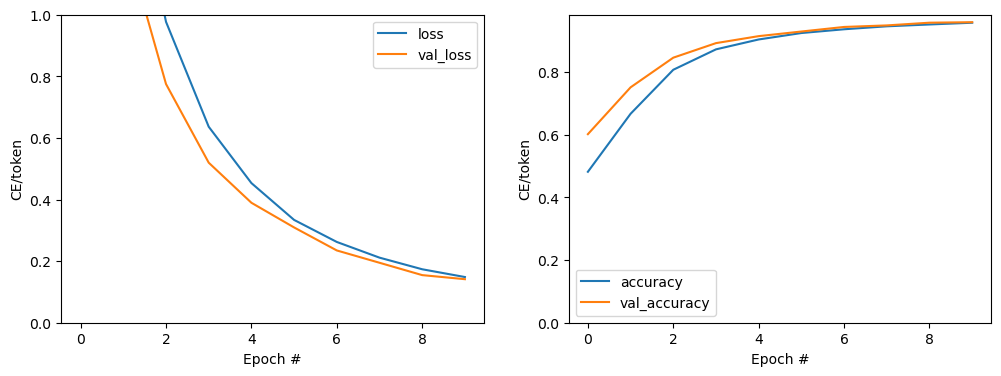

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

matplotlib.rc_file_defaults()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_ylim([0, max(plt.ylim())])
ax1.set_xlabel('Epoch #')
ax1.set_ylabel('CE/token')
ax1.legend()

ax2.plot(history.history['masked_acc'], label='accuracy')
ax2.plot(history.history['val_masked_acc'], label='val_accuracy')
ax2.set_ylim([0, max(plt.ylim())])
ax2.set_xlabel('Epoch #')
ax2.set_ylabel('CE/token')
ax2.legend()

<a id="6"></a>
# 6 - Inference

In [22]:
@Addressor.add_method
def Addressor_fix(self,
                  texts, *,
                  max_length=50,
                  random=False):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    logits_l = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state, logits = self.decoder.get_next_token(
            context, next_token, done,  state, random)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)
        logits_l.append(logits)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)
    self.all_logis = tf.concat(logits_l, axis=1)

    result = self.decoder.tokens_to_text(tokens)
    return result

@Addressor.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.Addressor_fix([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = utils.tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = utils.tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1, 1, 1)

    ax = sns.heatmap(model.last_attention_weights[0], annot=True, fmt=".3f")

    fontdict = {'fontsize': 14}

    ax.set_xticklabels(context, fontdict=fontdict)
    ax.set_yticklabels(output, fontdict=fontdict)

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

# Sandbox Section

In [23]:

for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[0:5])
    print()
    print(example_target_strings[0:5])
    break

tf.Tensor(
[b'580 Schenck Ave Kings 11207' b'2679 Ford St Kings 11235'
 b'15 203 St Saint Albans NY' b'48 177 St Queens 11366'
 b'548 Schenck Brooklyn Kings NY'], shape=(5,), dtype=string)

tf.Tensor(
[b'580 Schenck Ave Brooklyn Kings NY 11207'
 b'2679 Ford St Brooklyn Kings NY 11235'
 b'15 203 St Saint Albans Queens NY 11412'
 b'48 177 St Fresh Meadows Queens NY 11366'
 b'548 Schenck Ave Brooklyn Kings NY 11207'], shape=(5,), dtype=string)


In [24]:
context_raw = '963 76 St Brooklyn NY'
result = model.Addressor_fix([context_raw]) 
result.numpy()[0].decode()

'963 76 st brooklyn kings ny 11228 '

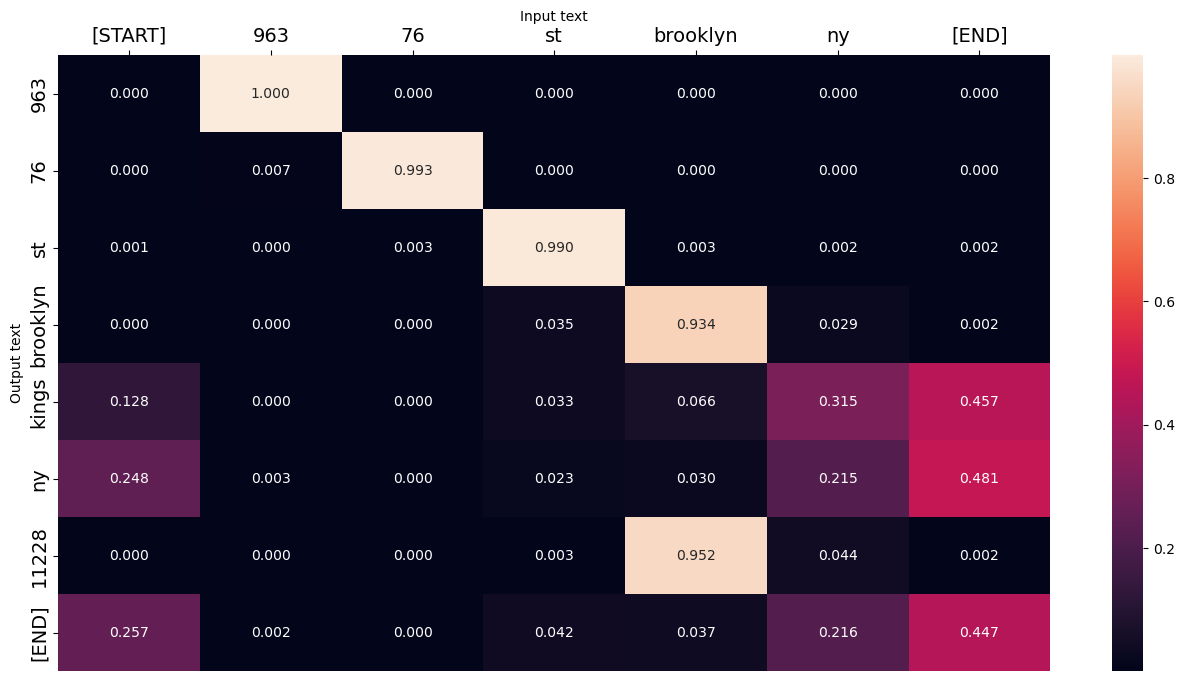

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

model.plot_attention(context_raw)

# Sandbox Section

In [196]:
hidden_state_logit = utils.top_5_index(model.all_logis[0][6],10)
model.decoder.tokens_to_text(hidden_state_logit)

<tf.Tensor: shape=(), dtype=string, numpy=b'11228 11236 11209 11214 11204 11219 11234 11232 11231 11220'>

The reason why 11237 is on the second on logic: https://maps.app.goo.gl/FoMGUksbecrb23tG9